# Задание 5. Обучение без учителя

- [x] Найти данные с количеством признаков хотя бы 50, на которых можно решить задачу кластеризации.
- [x] Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- [x] Самостоятельно реализуйте один из алгоритмов кластеризации, например **K-means**.
- [x] Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из **sklearn** (**KMeans**, **Affinity Propogation**, **DBSCAN** и тд).
- [x] При обучении использовать **подбор гиперпараметров**.
- [x] Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.
- [x] * (**+3 балла**) Также снизить размерность данных с помощью метода главных компонент **PCA** и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.
- [x] * (**+2 балла**) Визуализировать данные снижением размерности до 2 или 3 с помощью **PCA** и **t-SNE**. В случае проблем с производительностью **t-SNE**, можно сначала до какой то степени снизить размерность с помощью **PCA**, а затем запустить **t-SNE**.

## Описание датасета
[Big Five Personality Dataset](https://www.kaggle.com/datasets/tunguz/big-five-personality-test/data) — содержит 1 015 342 ответа на составленный психологами личностный тест и 110 признаков, учитывающих как сам ответ, так и сторонние показатели.

Для каждого вопроса была создана шкала ответов от 1 до 5, где 1 = не согласен, 3 = нейтрально, 5 = согласен. Примеры вопросов: "Я душа компании", "Я часто сочувствую другим людям", "Я стараюсь по возможности уклоняться от своих обязанностей". Некоторые вопросы противоречат другим, чтобы была возможность выявлять нечестные ответы.

В датасет также занесено время, потраченное на каждый вопрос, записанное в миллисекундах, страна проживания испытуемого и некоторое другие данные.

In [3]:
import kagglehub
import pandas as pd
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
)
from sklearn.cluster import AffinityPropagation
from statistics import mean
import seaborn as sns
import time
from itertools import product
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## EDA

In [4]:
folder = kagglehub.dataset_download("tunguz/big-five-personality-test")
dataset_path = os.path.join(folder, "IPIP-FFM-data-8Nov2018", "data-final.csv")

df = pd.read_csv(dataset_path, sep="\t")

df.tail(2)

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,dateload,screenw,screenh,introelapse,testelapse,endelapse,IPC,country,lat_appx_lots_of_err,long_appx_lots_of_err
1015339,2.0,4.0,3.0,4.0,2.0,2.0,1.0,4.0,2.0,4.0,...,2018-11-08 12:08:34,1920.0,1080.0,6.0,212.0,8,1,US,34.1067,-117.8067
1015340,4.0,2.0,4.0,2.0,4.0,1.0,4.0,2.0,4.0,4.0,...,2018-11-08 12:08:45,1920.0,1080.0,3.0,176.0,9,1,US,38.0,-97.0


In [5]:
df.dtypes

EXT1                     float64
EXT2                     float64
EXT3                     float64
EXT4                     float64
EXT5                     float64
                          ...   
endelapse                  int64
IPC                        int64
country                   object
lat_appx_lots_of_err      object
long_appx_lots_of_err     object
Length: 110, dtype: object

In [6]:
# dateload    The timestamp when the survey was started.
# screenw     The width the of user's screen in pixels
# screenh     The height of the user's screen in pixels.
# introelapse The time in seconds spent on the landing / intro page.
# testelapse  The time in seconds spent on the page with the survey questions.
# endelapse   The time in seconds spent on the finalization page.
# IPC         The number of records from the user's IP address in the dataset.
# country     The country, determined by technical information (NOT ASKED AS A QUESTION).
# lat_appx_lots_of_err    approximate latitude of user, determined by technical information.
# long_appx_lots_of_err   approximate longitude of user.

df = df[df["IPC"] == 1]
df = df.drop(
    [
        "dateload",
        "screenw",
        "screenh",
        "introelapse",
        "IPC",
        "country",
        "lat_appx_lots_of_err",
        "long_appx_lots_of_err",
        "testelapse",
        "endelapse",
    ],
    axis=1,
)

In [7]:
duplicate_rows_df = df[df.duplicated()]

print("Number of duplicate rows: ", duplicate_rows_df.shape)

df = df.drop_duplicates()
df = df.dropna()

print(df.isnull().sum())

Number of duplicate rows:  (2321, 100)
EXT1       0
EXT2       0
EXT3       0
EXT4       0
EXT5       0
          ..
OPN6_E     0
OPN7_E     0
OPN8_E     0
OPN9_E     0
OPN10_E    0
Length: 100, dtype: int64


In [8]:
df.shape

(694523, 100)

Из датасета были удалены признаки, которые не связаны напрямую с тестом (например, техническая информация об устройстве пользователя). Результаты были отфильтрованы, остись только те, где человек проходил тест ровно один раз. Общее число ответов после разведочного анализа сократилось почти на 32%.

In [9]:
scaler = MinMaxScaler()

df[df.columns] = scaler.fit_transform(df)

df.head(3)

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN1_E,OPN2_E,OPN3_E,OPN4_E,OPN5_E,OPN6_E,OPN7_E,OPN8_E,OPN9_E,OPN10_E
0,0.8,0.2,1.0,0.4,1.0,0.2,1.0,0.4,0.8,0.2,...,0.073982,0.000214,0.003363,0.000386,0.000476,0.028441,0.000144,0.000258,0.000869,0.038257
1,0.6,1.0,0.6,0.8,0.6,0.6,0.4,1.0,0.2,1.0,...,0.073981,0.000215,0.003352,0.000384,0.000492,0.028435,0.000140,0.000261,0.000870,0.038243
2,0.4,0.6,0.8,0.8,0.6,0.4,0.2,0.6,0.4,1.0,...,0.073980,0.000211,0.003352,0.000378,0.000476,0.028454,0.000138,0.000299,0.000857,0.038238


## Поиск оптимального числа кластеров

### Elbow Method

In [10]:
distortions = []
inertias = []

k_values = list(range(1,15))

cut_df = df[:50000]

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(cut_df)

    distortions.append(
        sum(
            np.min(distance.cdist(cut_df, kmeans.cluster_centers_, "euclidean"), axis=1)
            ** 2
        )
        / cut_df.shape[0]
    )
    inertias.append(kmeans.inertia_)

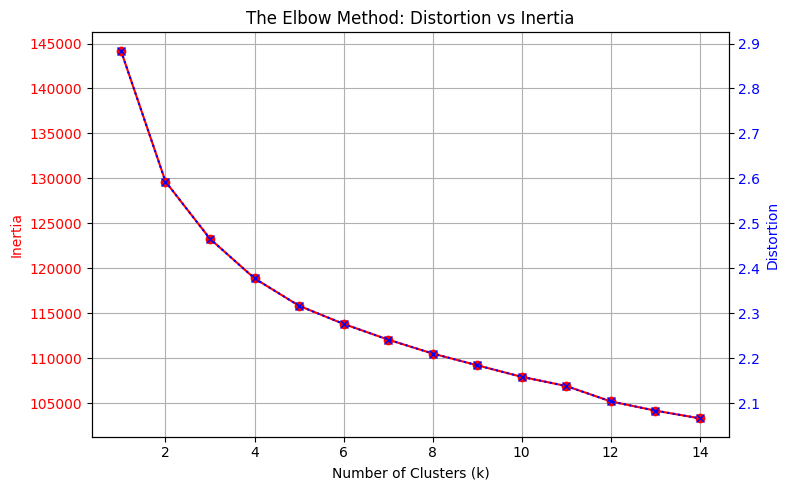

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.plot(k_values, inertias, "ro-", label="Inertia")
ax1.set_xlabel("Number of Clusters (k)")
ax1.set_ylabel("Inertia", color="red")
ax1.tick_params(axis="y", labelcolor="red")
ax1.grid()

ax2 = ax1.twinx()
ax2.plot(k_values, distortions, "bx--", label="Distortion")
ax2.set_ylabel("Distortion", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

plt.title("The Elbow Method: Distortion vs Inertia")
fig.tight_layout()
plt.show()

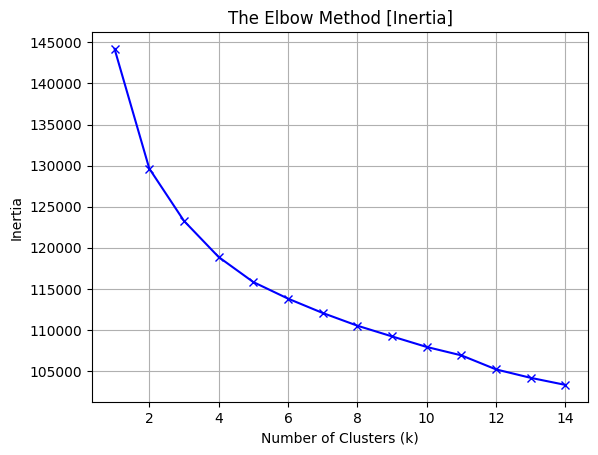

In [12]:
plt.plot(range(1, 15), inertias, "bx-")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("The Elbow Method [Inertia]")
plt.grid()
plt.show()

Из графиков следует, что оптимальным числом кластеров можно считать k = 3, 4, 5. В реальном психологическом исследовании, проводимом на этом датасете, выбрали число кластеров k = 5, поэтому далее так же будет использоваться именно оно.

## Реализация K-Means

In [13]:
def dist(x, y):
    return np.linalg.norm(x - y)


def find_centroid(cluster):
    if len(cluster) == 0:
        return None

    return np.mean(cluster, axis=0)


def my_kmeans(k: int, df: pd.DataFrame, max_iter: int = 100, tol: float = 0.0001):
    centroids = df.sample(n=k).to_numpy()

    for _ in range(max_iter):
        clusters = {i: [] for i in range(k)}

        for _, row in df.iterrows():
            point = row.to_numpy()

            distances = [dist(point, centroid) for centroid in centroids]
            cluster_id = np.argmin(distances)
            clusters[cluster_id].append(point)

        new_centroids = []

        for i in range(k):
            if clusters[i]:
                new_centroids.append(find_centroid(clusters[i]))
            else:
                new_centroids.append(centroids[i])

        new_centroids = np.array(new_centroids)

        if np.allclose(centroids, new_centroids, atol=tol):
            return clusters, new_centroids
        else:
            centroids = new_centroids

Теперь сравненим реализацию из sklearn (kmeans и AffinityPropagation) с написанной выше. Так как наиболее подходящие гиперпараметры ещё найдены не были, будем использовать одни и те же, чтобы убедиться, что новый алгоритм не отстаёт.

In [14]:
k = 5
test_df = df[:500]

kmeans = KMeans(n_clusters=k, random_state=42, max_iter=100, tol=0.0001).fit(test_df)
af = AffinityPropagation(max_iter=100, preference=-50, random_state=42).fit(test_df)

centroids_sk = kmeans.cluster_centers_
centroids_af = af.cluster_centers_
_, centroids_my = my_kmeans(k, test_df)

distortion_sk = (
    sum(np.min(distance.cdist(test_df, centroids_sk, "euclidean"), axis=1) ** 2)
    / test_df.shape[0]
)
distortion_af = (
    sum(np.min(distance.cdist(test_df, centroids_my, "euclidean"), axis=1) ** 2)
    / test_df.shape[0]
)
distortion_af = (
    sum(np.min(distance.cdist(test_df, centroids_af, "euclidean"), axis=1) ** 2)
    / test_df.shape[0]
)

labels_sk = kmeans.labels_
labels_af = af.labels_
labels = np.empty(len(test_df), dtype=int)

for i, point in enumerate(test_df.to_numpy()):
    distances = [np.linalg.norm(point - centroid) for centroid in centroids_my]
    labels[i] = np.argmin(distances)

silhouette_sk = silhouette_score(test_df, labels_sk)
silhouette_af = silhouette_score(test_df, labels)
silhouette_af = silhouette_score(test_df, labels_af)

# Index is the ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters
calinski_sk = calinski_harabasz_score(test_df, labels_sk)
calinski_af = calinski_harabasz_score(test_df, labels)
calinski_af = calinski_harabasz_score(test_df, labels_af)

print(distortion_sk, distortion_af, distortion_af)
print(silhouette_sk, silhouette_af, silhouette_af)
print(calinski_sk, calinski_af, calinski_af)

2.1740294620550262 2.698728140864598 2.698728140864598
0.05769549308646639 0.047724106711721545 0.047724106711721545
32.736538434905896 32.569642981638 32.569642981638


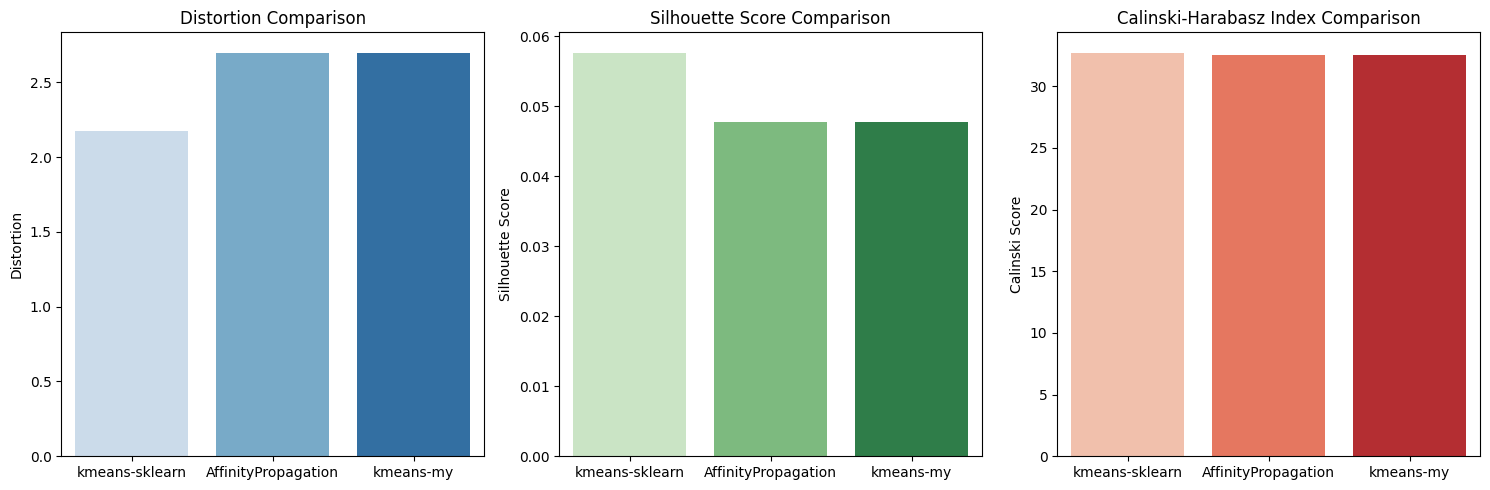

In [15]:
distortion_values = [distortion_sk, distortion_af, distortion_af]
silhouette_values = [silhouette_sk, silhouette_af, silhouette_af]
calinski_values = [calinski_sk, calinski_af, calinski_af]

labels = ["kmeans-sklearn", "AffinityPropagation", "kmeans-my"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.barplot(x=labels, y=distortion_values, ax=axes[0], palette="Blues", hue=labels)
axes[0].set_title("Distortion Comparison")
axes[0].set_ylabel("Distortion")

sns.barplot(x=labels, y=silhouette_values, ax=axes[1], palette="Greens", hue=labels)
axes[1].set_title("Silhouette Score Comparison")
axes[1].set_ylabel("Silhouette Score")

sns.barplot(x=labels, y=calinski_values, ax=axes[2], palette="Reds", hue=labels)
axes[2].set_title("Calinski-Harabasz Index Comparison")
axes[2].set_ylabel("Calinski Score")

plt.tight_layout()
plt.show()

По результатам сравнения видно, что при однинаковых начальных параметрах, реализация из sklearn справляется с поставленной задачей примерно так же хорошо, как наша собственная реализация. Теперь оценим время выполнения.

In [16]:
# Count time
kmeans_time, af_time, my_kmeans_time = [], [], []

for _ in range(100):
    start_time = time.time()
    _ = KMeans(n_clusters=k, random_state=42, max_iter=100, tol=0.0001).fit(test_df)
    kmeans_time.append(time.time() - start_time)

    start_time = time.time()
    _ = AffinityPropagation(max_iter=100, preference=-50, random_state=42).fit(test_df)
    af_time.append(time.time() - start_time)

    start_time = time.time()
    _, _ = my_kmeans(k, test_df)
    my_kmeans_time.append(time.time() - start_time)

kmeans_time, af_time, my_kmeans_time = (
    mean(kmeans_time),
    mean(af_time),
    mean(my_kmeans_time),
)

print(kmeans_time, af_time, my_kmeans_time)


0.005046913623809815 0.09644045591354371 0.3410325908660889


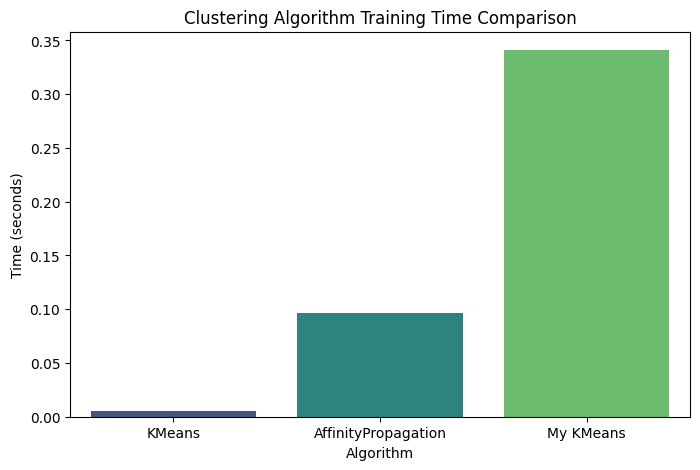

In [17]:
time_data = pd.DataFrame(
    {
        "Algorithm": ["KMeans", "AffinityPropagation", "My KMeans"],
        "Training Time (seconds)": [kmeans_time, af_time, my_kmeans_time],
    }
)

# Draw plots
plt.figure(figsize=(8, 5))
sns.barplot(
    x="Algorithm",
    y="Training Time (seconds)",
    data=time_data,
    palette="viridis",
    hue="Algorithm",
)
plt.title("Clustering Algorithm Training Time Comparison")
plt.ylabel("Time (seconds)")
plt.xlabel("Algorithm")
plt.show()

Из представленных выше графиков видно, что алгоритмы из sklearn значительно быстрее реализации my_KMeans. Скорее всего это связано с тем, что sklearn использует векторные операции и в целом написан более эффективно, чем прямая реализация алгоритма kmeans на языке Python.

## Подбор гиперпараметров

После того, как результаты работы всех трёх представленных алгоритмов были получены, попробуем найти оптимальные значения гиперпараметров, чтобы улучшить эти результаты. 

Сначала определим функцию, возвращающую метрики, используя при этом переданные ей гиперпараметры для запуска алгоритмов:

In [18]:
k = 5
test_df = df[:500]


def get_distortion(test_df, centroids):
    return (
        sum(np.min(distance.cdist(test_df, centroids, "euclidean"), axis=1) ** 2)
        / test_df.shape[0]
    )


def get_labels(test_df, centroids):
    labels = np.empty(len(test_df), dtype=int)

    for i, point in enumerate(test_df.to_numpy()):
        distances = [np.linalg.norm(point - centroid) for centroid in centroids]
        labels[i] = np.argmin(distances)

    return labels


def get_metrices_sk_kmeans(max_iter, tol, test_df=test_df):
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=max_iter, tol=tol).fit(
        test_df
    )

    centroids_sk = kmeans.cluster_centers_

    distortion_sk = get_distortion(test_df, centroids_sk)
    labels_sk = kmeans.labels_
    silhouette_sk = silhouette_score(test_df, labels_sk)
    calinski_sk = calinski_harabasz_score(test_df, labels_sk)

    return {
        "distortion": distortion_sk,
        "silhouette": silhouette_sk,
        "calinski": calinski_sk,
    }


def get_metrices_my_kmeans(max_iter, tol, test_df=test_df):
    _, centroids_my = my_kmeans(k, test_df, max_iter=max_iter, tol=tol)

    labels = get_labels(test_df, centroids_my)
    distortion_my = get_distortion(test_df, centroids_my)
    silhouette_my = silhouette_score(test_df, labels)
    calinski_my = calinski_harabasz_score(test_df, labels)

    return {
        "distortion": distortion_my,
        "silhouette": silhouette_my,
        "calinski": calinski_my,
    }


def get_metrices_af(max_iter, convergence_iter, damping, test_df=test_df):
    af = AffinityPropagation(
        damping=damping,
        max_iter=max_iter,
        convergence_iter=convergence_iter,
        random_state=42,
    ).fit(test_df)
    centroids_af = af.cluster_centers_
    labels = af.labels_

    distortion_af = get_distortion(test_df, centroids_af)
    silhouette_af = silhouette_score(test_df, labels)
    calinski_af = calinski_harabasz_score(test_df, labels)

    return {
        "distortion": distortion_af,
        "silhouette": silhouette_af,
        "calinski": calinski_af,
    }

Запустим подбор гиперпараметров. 

Для алгоритмов KMeans будут использоваться параметры:
- max_iter: [100, 200, 300, 400, 500]
- tol: [1e-4, 1e-3, 1e-2, 1e-1]

Для AffinityPropagation:
- max_iter: [100, 200, 300, 400, 500]
- convergence_iter: [5, 10, 15, 20]
- damping: [0.5, 0.6, 0.7, 0.8, 0.9]

In [19]:
def grid_search_sk_kmeans():
    max_iter_vals = [100, 200, 300, 400, 500]
    tol_vals = [1e-4, 1e-3, 1e-2, 1e-1]
    
    best_metrices = {}

    best_score = -np.inf
    best_params = None
    
    for max_iter, tol in product(max_iter_vals, tol_vals):
        metrics = get_metrices_sk_kmeans(max_iter, tol)
        score = metrics["silhouette"]
        
        if score > best_score:
            best_score = score
            best_metrices = metrics
            best_params = {"max_iter": max_iter, "tol": tol}
    
    return best_params, best_metrices

def grid_search_my_kmeans():
    max_iter_vals = [100, 200, 300, 400, 500]
    tol_vals = [1e-4, 1e-3, 1e-2, 1e-1]
    
    best_metrices = {}

    best_score = -np.inf
    best_params = None
    
    for max_iter, tol in product(max_iter_vals, tol_vals):
        metrics = get_metrices_my_kmeans(max_iter, tol)
        score = metrics["silhouette"]
        
        if score > best_score:
            best_score = score
            best_metrices = metrics
            best_params = {"max_iter": max_iter, "tol": tol}
    
    return best_params, best_metrices

def grid_search_af():
    max_iter_vals = [100, 200, 300, 400, 500]
    convergence_iter_vals = [5, 10, 15, 20]
    damping_vals = [0.5, 0.6, 0.7, 0.8, 0.9]
    
    best_metrices = {}

    best_score = -np.inf
    best_params = None
    
    for max_iter, convergence_iter, damping in product(max_iter_vals, convergence_iter_vals, damping_vals):
        metrics = get_metrices_af(max_iter, convergence_iter, damping)
        score = metrics["silhouette"]
        
        if score > best_score:
            best_score = score
            best_metrices = metrics
            best_params = {
                "max_iter": max_iter,
                "convergence_iter": convergence_iter,
                "damping": damping
            }
    
    return best_params, best_metrices

In [20]:
sk_kmeans_best_params, sk_kmeans_best_metrices = grid_search_sk_kmeans()
my_kmeans_best_params, my_kmeans_best_metrices = grid_search_my_kmeans()
af_best_params, af_best_metrices = grid_search_af()

best_metrices = {
    "KMeans": sk_kmeans_best_metrices,
    "My KMeans": my_kmeans_best_metrices,
    "AffinityPropagation": af_best_metrices,
}

print(sk_kmeans_best_params)
print(my_kmeans_best_params)
print(af_best_params)

{'max_iter': 100, 'tol': 0.0001}
{'max_iter': 200, 'tol': 0.001}
{'max_iter': 100, 'convergence_iter': 5, 'damping': 0.9}


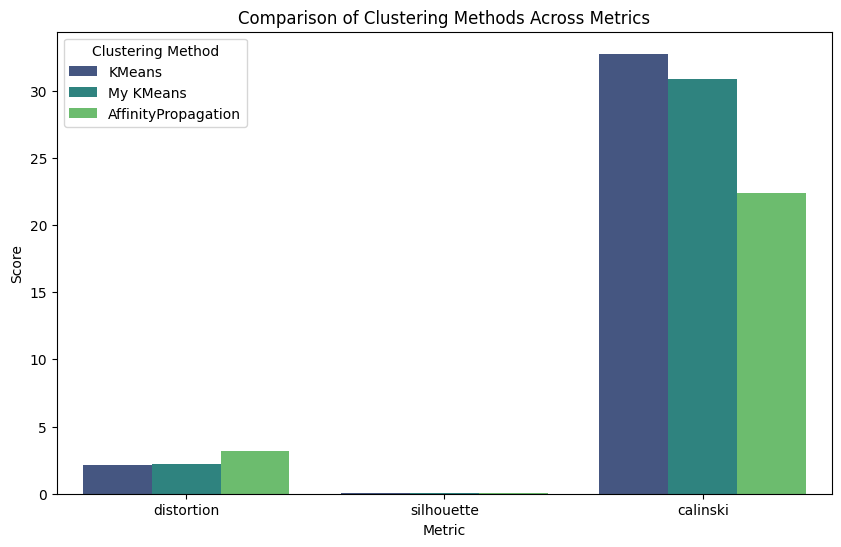

In [21]:
metrics = ["distortion", "silhouette", "calinski"]
methods = ["KMeans", "My KMeans", "AffinityPropagation"]

data = []
for method, metrics in best_metrices.items():
    for metric, value in metrics.items():
        data.append({"Method": method, "Metric": metric, "Value": value})

param_df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.barplot(data=param_df, x="Metric", y="Value", hue="Method", palette="viridis")

plt.title("Comparison of Clustering Methods Across Metrics")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.legend(title="Clustering Method")

plt.show()

В результате были получены лучшие гиперпараметры для обучения моделей.

## PCA + t-SNE

Теперь попробуем снизить размерность данных и оценить, как это повлияет на результат. 

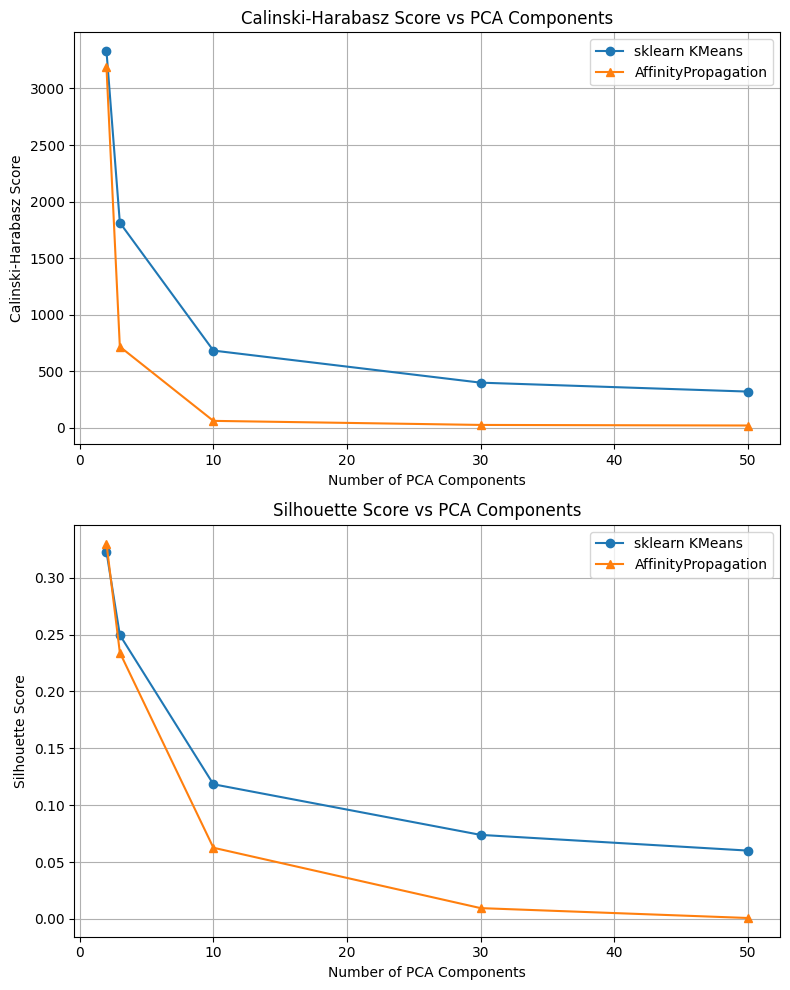

In [22]:
n_components_list = [50, 30, 10, 3, 2]

sk_kmeans_calinski, sk_kmeans_silhouette = [], []
af_calinski, af_silhouette = [], []

test_df = df[:5000]

for n_components in n_components_list:
    pca = PCA(n_components=n_components).fit_transform(test_df)
    pca_df = pd.DataFrame(pca)

    sk_kmeans_metrices = get_metrices_sk_kmeans(100, 0.0001, pca_df)
    sk_kmeans_calinski.append(sk_kmeans_metrices["calinski"])
    sk_kmeans_silhouette.append(sk_kmeans_metrices["silhouette"])

    af_metrices = get_metrices_af(100, 5, 0.9, pca_df)
    af_calinski.append(af_metrices["calinski"])
    af_silhouette.append(af_metrices["silhouette"])


fig, axes = plt.subplots(2, 1, figsize=(8, 10))

# Calinski-Harabasz Score Plot
axes[0].plot(n_components_list, sk_kmeans_calinski, marker='o', label="sklearn KMeans")
axes[0].plot(n_components_list, af_calinski, marker='^', label="AffinityPropagation")
axes[0].set_xlabel("Number of PCA Components")
axes[0].set_ylabel("Calinski-Harabasz Score")
axes[0].set_title("Calinski-Harabasz Score vs PCA Components")
axes[0].legend()
axes[0].grid(True)

# Silhouette Score Plot
axes[1].plot(n_components_list, sk_kmeans_silhouette, marker='o', label="sklearn KMeans")
axes[1].plot(n_components_list, af_silhouette, marker='^', label="AffinityPropagation")
axes[1].set_xlabel("Number of PCA Components")
axes[1].set_ylabel("Silhouette Score")
axes[1].set_title("Silhouette Score vs PCA Components")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

Теперь применим t-SNE, чтобы получить двумерное пространство, которое можно изобразить.

In [23]:
test_df = df[:10000]

tsne = TSNE(n_components=2, random_state=42).fit_transform(
    test_df
)
tsne_df = pd.DataFrame(tsne, columns=["TSNE_X", "TSNE_Y"])

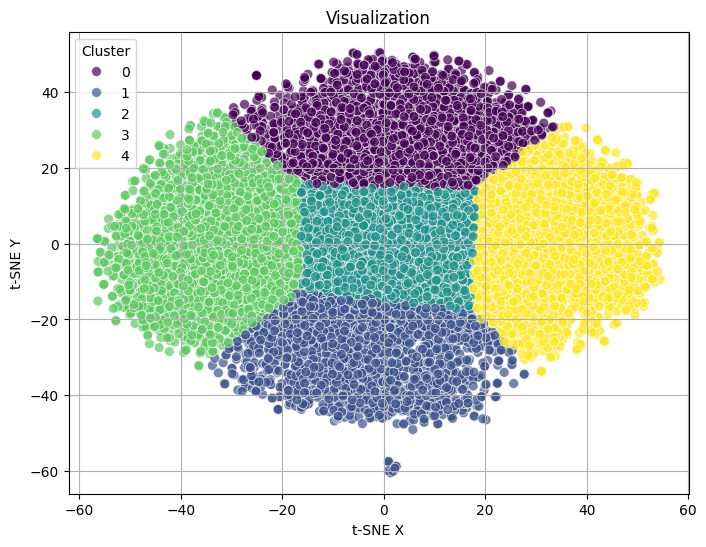

In [24]:
kmeans = KMeans(n_clusters=5, random_state=42, max_iter=100, tol=0.000001)
labels = kmeans.fit_predict(tsne_df)

tsne_df["Cluster"] = labels

plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_df["TSNE_X"], y=tsne_df["TSNE_Y"], hue=tsne_df['Cluster'], palette='viridis', s=50, alpha=0.7)
plt.xlabel("t-SNE X")
plt.ylabel("t-SNE Y")
plt.title("Visualization")
plt.grid(True)

plt.show()

## Вывод

Был выбран датасет, содержащий ответы на тест личности более чем миллиона человек.

В работе были использованы и сравнены алгоритмы кластеризации: KMeans, Affinity Propagation, а также собственная реализация KMeans.  

Размерность данных была уменьшена с помощью PCA, получившийся результат был кластеризован, также было измерено качество самой кластеризации.  

Также размерность была уменьшена с помощью t-SNE до двумерной и визуалезована по кластерам.
